In [51]:
import os, sys, glob
import warnings
warnings.filterwarnings("ignore")

import argparse
parser = argparse.ArgumentParser()
# Dataset
parser.add_argument('--set', type=str, default='valid')
# Model/Config
parser.add_argument('--step', type=str, default='050000')
parser.add_argument('--ckpt_selector', type=str, default='ema')
parser.add_argument('--cfg_name', type=str, default=None)
parser.add_argument('--log_dir', type=str, default=None)
# Interpolation
parser.add_argument('--interpolate', nargs='+', default=None)
parser.add_argument('--interpolate_step', type=int, default=15)
parser.add_argument('--interpolate_noise', action='store_true', default=False)
parser.add_argument('--lerp', action='store_true', default=False)
parser.add_argument('--slerp', action='store_true', default=False)
parser.add_argument('--uncond_sampling', action='store_true', default=False)
parser.add_argument('--uncond_sampling_iters', type=int, default=1)
parser.add_argument('--reverse_sampling', action='store_true', default=False)
parser.add_argument('--separate_reverse_sampling', action='store_true', default=False)
# Samples selection
parser.add_argument('--n_subject', type=int, default=-1)
parser.add_argument('--sample_pair_json', type=str, default=None)
parser.add_argument('--sample_pair_mode', type=str, default=None)
parser.add_argument('--src_dst', nargs='+', default=[])
# Pertubation the image condition
parser.add_argument('--perturb_img_cond', action='store_true', default=False)
parser.add_argument('--perturb_mode', type=str, default='zero')
parser.add_argument('--perturb_where', nargs='+', default=[])

# Rendering
parser.add_argument('--render_mode', type=str, default="shape")
parser.add_argument('--rotate_normals', action='store_true', default=False)
# Diffusion
parser.add_argument('--diffusion_steps', type=int, default=1000)
parser.add_argument('--denoised_clamp', type=float, default=None)
# Misc.
parser.add_argument('--seed', type=int, default=23)
parser.add_argument('--gpu_id', type=str, default="0")
parser.add_argument('--save_intermediate', action='store_true', default=False)
parser.add_argument('--postfix', type=str, default='')
parser.add_argument('--ovr_img', type=str, default=None)
parser.add_argument('--ovr_mod', action='store_true', default=False)
parser.add_argument('--norm_img', action='store_true', default=False)
parser.add_argument('--use_global_norm', action='store_true', default=False)
parser.add_argument('--norm_space', type=str, default='rgb')

args = parser.parse_args(args=[])

import os, sys, glob
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL, cv2
import json
import copy
import time
import torchvision
import pytorch_lightning as pl
import scipy
sys.path.insert(0, '../../')
from guided_diffusion.script_util import (
    seed_all,
)

from guided_diffusion.tensor_util import (
    make_deepcopyable,
    dict_slice,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, figsize=(8, 6)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

# Sample utils
sys.path.insert(0, '../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    inference_utils, 
    mani_utils,
)
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'

In [37]:
seed_all(47)

################ SETTINGS ################
# args.cfg_name = "Masked_Face_woclip+UNet_BgNoHead_share_dpm_noise_masking+shadow.yaml"
# args.log_dir = "Masked_Face_woclip+UNet_BgNoHead_share_dpm_noise_masking+shadow"
args.cfg_name = "Masked_Face_woclip+BgNoHead+shadow.yaml"
args.log_dir = "Masked_Face_woclip+BgNoHead+shadow"

args.step = '050000'
args.ckpt_selector = 'ema'
args.set = 'valid'
# args.sample_pair_json = './sample_json/itw_samples.json'
# args.sample_pair_json = './sample_json/ipynb_samples.json'
args.sample_pair_json = './sample_json/debug_multipie.json'
args.sample_pair_mode = 'pair'
dataset = 'mp'
# dataset = 'itw'

# Load Ckpt
if args.cfg_name is None:
    args.cfg_name = args.log_dir + '.yaml'
ckpt_loader = ckpt_utils.CkptLoader(log_dir=args.log_dir, cfg_name=args.cfg_name)
cfg = ckpt_loader.cfg

print(f"[#] Sampling with diffusion_steps = {args.diffusion_steps}")
cfg.diffusion.diffusion_steps = args.diffusion_steps
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=args.ckpt_selector, step=args.step)
model_dict = inference_utils.eval_mode(model_dict)

# Load dataset

if dataset == 'itw':
    img_dataset_path = f"/data/mint/DPM_Dataset/ITW/itw_images_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ITW/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'ITW'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/itw_images_aligned/'
elif dataset == 'ffhq':
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
    img_ext = '.jpg'
    cfg.dataset.training_data = 'ffhq_256_with_anno'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
elif dataset == 'mp':
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'MultiPIE'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise NotImplementedError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, avg_dict = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector,
    rmv_params=cfg.param_model.rmv_params,
    set_=args.set,
    cfg=cfg,
    mode='sampling',
    img_ext=img_ext,
)


[#] Model Path : 
#0 : /data/mint/model_logs_mount/v12/Masked_Face_woclip+BgNoHead+shadow/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/Final_Candidates/Masked_Face_woclip+BgNoHead+shadow.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/Final_Candidates/Masked_Face_woclip+BgNoHead+shadow.yaml')

[#] Sampling with diffusion_steps = 1000
[#] Available ckpt :  ['_000000.pt', '_000000.pt', '_010000.pt', '_010000.pt', '_020000.pt', '_020000.pt', '_030000.pt', '_030000.pt', '_040000.pt', '_040000.pt', '_050000.pt', '_050000.pt', '_060000.pt', '_060000.pt', '_070000.pt', '_070000.pt', '_080000.pt', '_080000.pt', '_090000.pt', '_090000.pt', '_100000.pt', '_100000.pt', '_110000.pt', '_110000.pt', '_120000.pt', '_120000.pt', '_130000.pt', '_130000.pt', '_140000.pt', '_140000.pt', '_150000.pt', '_150000.pt', '_160000.pt', '_160000.pt', '_170000.pt', '_170000.pt', '_180000.pt', '_180000.pt', '_190000.pt', '_190000.pt', '_200000.pt', '_200000.pt', '_21

Loading deca params...: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead']
DPM Image condition :  [None]


In [3]:
data_size = dataset.__len__()
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{args.set}")

denoised_fn = None
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, 
                                            diffusion=diffusion, 
                                            reverse_fn=diffusion.ddim_reverse_sample_loop, 
                                            forward_fn=diffusion.ddim_sample_loop,
                                            denoised_fn=denoised_fn,
                                            cfg=cfg,
                                            args=args)

# DECA Estimate

In [34]:
sys.path.insert(1, '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

def deca_estimate(img_path):
    mask_dir = '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/'
    testdata = datasets.TestData(img_path, iscrop=True, face_detector='fan', sample_step=10)
    f_mask = np.load(f'{mask_dir}/FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
    v_mask = np.load(f'{mask_dir}/FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
    mask={
        'v_mask':v_mask['face'].tolist(),
        'f_mask':f_mask['face'].tolist()
    }
    deca_cfg.model.use_tex = False
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.extract_tex = False
    deca = DECA(config = deca_cfg, device=device, mode='deca', mask=mask)
    
    print(testdata[0].keys())
    name = testdata[0]['imagename']
    ext = testdata[0]['imageext']
    images = testdata[0]['image'].to(device)[None,...]
    original_image = testdata[0]['original_image'][None, ...].to(device)
    tform = testdata[0]['tform'][None, ...]
    
    with th.no_grad():
        codedict = deca.encode(images)
        tform_inv = th.inverse(tform).transpose(1,2).to(device)
        _, orig_visdict = deca.decode(codedict, render_orig=True, original_image=original_image, tform=tform_inv, use_template=False, mean_cam=None)    
        orig_visdict['inputs'] = original_image
        
    del deca
    
    return codedict, orig_visdict
    

creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
dict_keys(['image', 'imagename', 'imageext', 'tform', 'original_image'])
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
dict_keys(['image', 'imagename', 'imageext', 'tform', 'original_image'])


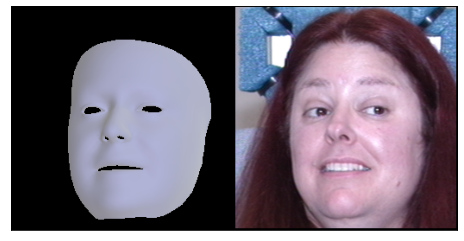

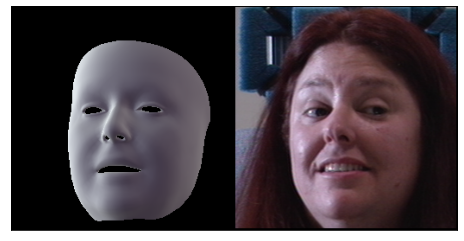

In [52]:
# Rendered
src_img_path = '/data/mint/DPM_Dataset/MultiPIE/mp_aligned/valid/046_01_01_051_07.png'
src_deca_p, visdict = deca_estimate(img_path=src_img_path)
vis_img = th.cat((visdict['shape_images'], visdict['inputs']))
show(torchvision.utils.make_grid(vis_img))

dst_img_path = '/data/mint/DPM_Dataset/MultiPIE/mp_aligned/valid/046_01_01_051_13.png'
dst_deca_p, visdict = deca_estimate(img_path=dst_img_path)
vis_img = th.cat((visdict['shape_images'], visdict['inputs']))
show(torchvision.utils.make_grid(vis_img))

In [49]:
src_img = PIL.Image.open(src_img_path).resize((128, 128), PIL.Image.ANTIALIAS)
src_img = np.array(src_img)



(128, 128, 3)


# Relighting

In [ ]:
def relight(dat, model_kwargs, norm_img, n_step=3, sidx=0, didx=1):
    show(torchvision.utils.make_grid((dat + 1) * 0.5), figsize=(4, 8))
    # Rendering
    # args.interpolate = ['render_face']
    args.interpolate = ['light']
    cond = copy.deepcopy(model_kwargs)
    cond = make_condition(cond=cond, 
                        src_idx=sidx, dst_idx=didx, 
                        n_step=n_step, itp_func=mani_utils.slerp)

    # Reverse 
    cond_rev = copy.deepcopy(cond)
    cond_rev = dict_slice(in_d=cond_rev, keys=cond_rev.keys(), n=1) # Slice only 1st image out for inversion
    if cfg.img_cond_model.apply:
        cond_rev = pl_sampling.forward_cond_network(model_kwargs=cond_rev)
        
    reverse_ddim_sample = pl_sampling.reverse_proc(x=dat[0:1, ...], model_kwargs=cond_rev, store_mean=True)
    noise_map = reverse_ddim_sample['final_output']['sample']
    rev_mean = reverse_ddim_sample['intermediate']
    
    #NOTE: rev_mean WILL BE MODIFIED; This is for computing the ratio of inversion (brightness correction).
    sample_ddim = pl_sampling.forward_proc(
        noise=noise_map,
        model_kwargs=cond_rev,
        store_intermediate=False,
        rev_mean=rev_mean)

    # Relight!
    cond['use_render_itp'] = True
    if cfg.img_cond_model.apply:
        cond_relight = pl_sampling.forward_cond_network(model_kwargs=cond)
        
    assert noise_map.shape[0] == 1
    rev_mean_first = [x[:1] for x in rev_mean]
    
    relight_out = pl_sampling.forward_proc(
        noise=th.repeat_interleave(noise_map, repeats=cond_relight["cond_img"].shape[0], dim=0),
        model_kwargs=cond_relight,
        store_intermediate=False,
        add_mean=rev_mean_first)
    return relight_out["final_output"]["sample"]

In [ ]:
# assert False
all_img_idx, all_img_name, args.n_subject = mani_utils.get_samples_list(args.sample_pair_json, 
                                                                        args.sample_pair_mode, 
                                                                        args.src_dst, img_path, 
                                                                        args.n_subject)

# for idx in [1, 2, 3, 4]:
for idx in [0, 1]:
# for idx in range(len(all_img_idx)):
    img_idx = all_img_idx[idx]
    img_name = all_img_name[idx]
    n_step = 3

    dat = th.utils.data.Subset(dataset, indices=img_idx)
    subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                        shuffle=False, num_workers=24)
                                
    # Load image & condition                        
    # for i in ['60182.jpg', '60008.jpg', '68782.jpg', -1.0, -0.5, 0.0, 0.5, 1.0]:
    dat, model_kwargs = list(iter(subset_loader))[0]
    d_tmp = []
    # rpl_bg = [None, {'image':model_kwargs['image_name'][0]}, {'balance_Ndist':{'sd':0.1, 'clip':True}}, {'balance_Ndist':{'sd':0.5, 'clip':True}}, {'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':True}}] 
    # rpl_bg = [None, {'balance_Ndist':{'sd':0.1, 'clip':True}} , {'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':True}}]
    # rpl_bg = [{'balance_Ndist':{'sd':0.1, 'clip':True}}]
    rpl_bg = [None]
    all_output = []
    for i in rpl_bg:
        print("Replacing : ", i)
        if i is not None:
            d, fg, bg, m, om = replace_bg(image_name=model_kwargs['image_name'][0].split('.')[0], dilate=10, rpl=i, imgsize=128)
            dat = fg[None][0:1, ...].cuda()
            model_kwargs['faceseg_bg_noface&nohair_mask'] = ~m[None]
            model_kwargs['original'] = d[None]
            model_kwargs['original_mask'] = om[None]
        else:
            dat = dat[0:1, ...].cuda()

        #TODO: Override the model_kwargs argument for 'mask'=m, 'image'=dat, 'bg'=bg
        # print(model_kwargs.keys())
        model_kwargs['faceseg_bg_noface&nohair_img'] = dat
        model_kwargs['image'] = dat
        
        # show(torchvision.utils.make_grid(th.clip((model_kwargs['faceseg_bg_noface&nohair_img']+1)*0.5, 0, 1)), figsize=(10, 15))
        # show(torchvision.utils.make_grid(model_kwargs['faceseg_bg_noface&nohair_mask']*1.0), figsize=(10, 15))
        # # ['faceseg_bg_noface&nohair_img'] = m[None]
        # print(model_kwargs['faceseg_bg_noface&nohair_img'].shape, model_kwargs['faceseg_bg_noface&nohair_mask'].shape)
        # print(bg.shape, fg.shape, m.shape)
        # assert False
        
        
        out = relight(dat=dat.clone(), model_kwargs=model_kwargs, n_step=3, norm_img=False)
        out = th.cat(((dat+1) * 0.5, (out+1) * 0.5), dim=0)
        all_output.append(torchvision.utils.make_grid(out))
    all_output = th.clip(th.cat((all_output), dim=1), 0, 1)
    show(all_output, figsize=(15, 15))
    